# Imports

## Modules

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor

## Data

In [2]:
data = pd.read_csv('Data.csv', sep=';')
data.head()

,row_num,locale,day_of_week,hour_of_day,agent_id,entry_page,path_id_set,traffic_type,session_durantion,hits
0,988681,L6,Monday,17,1,2111,31672;0,6,7037,\N
1,988680,L2,Thursday,22,10,2113,31965;0,2,49,14
2,988679,L4,Saturday,21,2,2100,0;78464,1,1892,14
3,988678,L3,Saturday,19,8,2113,51462,6,0,1
4,988677,L2,Tuesday,6,10,2116,31931;0,1,2,3


## Data analysis

We check for null values to know the dataset better.<br>

In [3]:
data.isnull().sum(axis=0)

row_num                 0
locale                  0
day_of_week             0
hour_of_day             0
agent_id                0
entry_page              0
path_id_set          4889
traffic_type            0
session_durantion       0
hits                    0
dtype: int64

We find out that 'path_id_set' has null values. But we also found out that 'session_durantion' and 'hits' contain '\N' values, so we take care of it.

In [4]:
# set proper datatypes
data['row_num'] = data['row_num'].astype(np.int)
data['locale'] = data['locale'].astype(str)
data['day_of_week'] = data['day_of_week'].astype(str)
data['hour_of_day'] = data['hour_of_day'].astype(np.int)
data['agent_id'] = data['agent_id'].astype(np.int)
data['entry_page'] = data['entry_page'].astype(np.int)
data.loc[data['path_id_set'].notnull(), 'path_id_set'] = data.loc[data['path_id_set'].notnull(), 'path_id_set'].astype(str)
data['traffic_type'] = data['traffic_type'].astype(str)

# 'session_durantion' and 'hits' contain '\N' values
# we will replace it with 0 for 'session_durantion' and NULL for 'hits'
data['session_durantion'] = pd.to_numeric(data['session_durantion'], errors='coerce')
data['session_durantion'] = data['session_durantion'].fillna(0)
data['hits'] = pd.to_numeric(data['hits'], errors='coerce')

## Values of the main features

We get through each column to see, which values it contains to have an idea about how to treat them in the model.

### The platform of the session

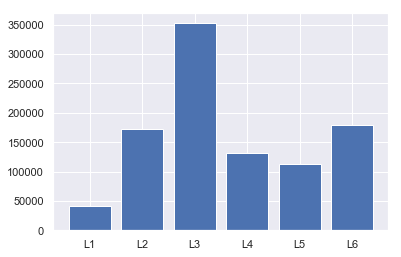

In [5]:
locales = data['locale'].value_counts().sort_index()

# show plot
plt.bar(locales.index, locales.values)
plt.show()

There are 6 platforms of the session and we will treat them as categorical variable.

### The day of the week of the session

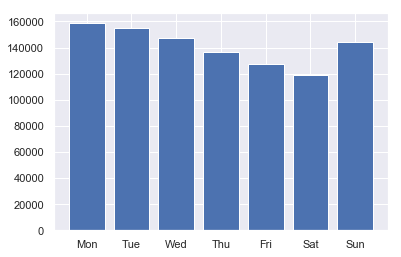

In [6]:
day_of_week = data['day_of_week'].value_counts()[['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']]

# show plot
labels = [day[:3] for day in day_of_week.index] # display just first 3 characters of the day of the week
plt.bar(labels, day_of_week.values)
plt.show()

There are also 7 days of the week of the session. We will also treat it as a categorical variable.

### The hour of the day of the session

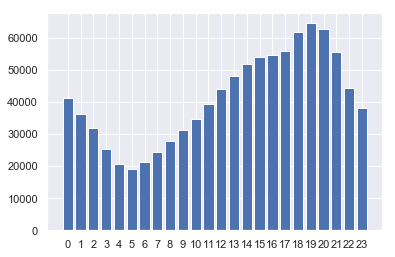

In [7]:
hour_of_day = data['hour_of_day'].value_counts().sort_index()

# show plot
plt.bar(hour_of_day.index, hour_of_day.values)
plt.xticks(np.arange(24)) # set x ticks to be for each hour: np.arange(24) = [1,2,3,..,23]
plt.show()

There are 24 hours. They can be treated as categorical values and as continious values. We will perform one-hot-encoding (will be explained futher) for categorical variables later. But we will treat this variable as continous to keep the dimensionality of the dataset smaller.

### The device used for the session

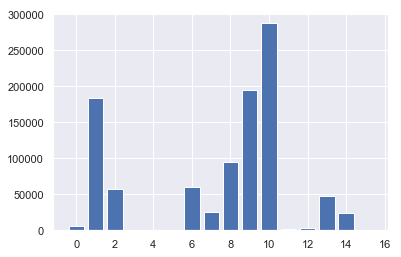

In [8]:
agent_id = data['agent_id'].value_counts().sort_index()

# show plot
plt.bar(agent_id.index, agent_id.values)
plt.show()

There are 16 devices used for the session. We will treat this variable as categorical.

### Entry page

There are 147 entry pages in total. We will keep the most frequent entry pages (min. 2000 records to keep the page).

In [9]:
entry_page = data['entry_page'].value_counts().sort_index()
print(entry_page[entry_page > 2000])

2100    178912
2111     83687
2113    333163
2114     74050
2115     16733
2116    195904
2226      9840
2227      3024
2316      3332
2700     58330
8001     16309
Name: entry_page, dtype: int64


In [10]:
keep_entry_pages = entry_page[entry_page > 2000].index
data.loc[data['entry_page'].isin(keep_entry_pages) == False, 'entry_page'] = -1

There are 11 entry pages, which have more than 2000 records, so we will keep them and treat as categories. All the others will belong to category '-1'.

## Locations

We also have the information about all the locations, which were visited during the session. There would be too many categories, if we treated this data as categorical, which we cannot afford. But this data can still be useful for us. We can create a new variable, which will stand for number of pages visited during the session and named 'n_pages_visited'.

In [11]:
data.loc[data['path_id_set'].notnull(), 'n_pages_visited'] = \
    data.loc[data['path_id_set'].notnull(), 'path_id_set'].apply(lambda x: len(x.split(';')))

data.loc[data['path_id_set'].isnull() & (data['session_durantion'] > 0), 'n_pages_visited'] = 1
data.loc[data['path_id_set'].isnull() & (data['session_durantion'] == 0), 'n_pages_visited'] = 0

In [12]:
data.head()

,row_num,locale,day_of_week,hour_of_day,agent_id,entry_page,path_id_set,traffic_type,session_durantion,hits,n_pages_visited
0,988681,L6,Monday,17,1,2111,31672;0,6,7037.0,NaN,2.0
1,988680,L2,Thursday,22,10,2113,31965;0,2,49.0,14.0,2.0
2,988679,L4,Saturday,21,2,2100,0;78464,1,1892.0,14.0,2.0
3,988678,L3,Saturday,19,8,2113,51462,6,0.0,1.0,1.0
4,988677,L2,Tuesday,6,10,2116,31931;0,1,2.0,3.0,2.0


# Prepare data for training

#### We are going to perform several preprocessing steps:

1) Remove locations variable ('path_id_set'), because we do not need it anymore.<br>
2) Perform <b>one-hot-encoding</b> for categorical variables.<br>
3) There are a few extreme values of a target variable ('hits'), which we will replace by 300 (300 is chosen manually). Extreme values occur rarely, are difficult to predict and can cause problems while training, so we will focus on predicting casual occations (99.8%).

What is <b>one-hot-encoding</b>?<br>
ML algorithms do not understand words, they understand numbers. However, we have several categorical variables and we have to find a way to include the information into the model. We will perform one-hot-encoding for it. When we perform this technique one feature variable is transofrmed into a set of variables (equal to = number of categories - 1), where each variable denotes presense of a specific category. The values in this columns are boolean (where 1 means presense of the category and 0 means absense of the category).<br>

Example: we have a category color, which can have 3 values: red, green and blue. In this case we will transform the variable into 2(n-1) new features: is_red and is_green. Note: there is no is_blue variable. Let's imagine we have a record 'apple', then it will have is_red=1 and is_green=0. If we have a record 'sky', it will have is_red=0 and is_green=0. We do not have is_blue due to the problem of autocorrelation, because it's enough to know that the record is not red and not green to know that it is blue.

In [13]:
# remove 'path_id_set'
data = data.drop('path_id_set', axis=1)

# one-hot-encoding
data = pd.get_dummies(data, columns=['locale', 'day_of_week', 'agent_id', 'entry_page', 'traffic_type'], drop_first=True)

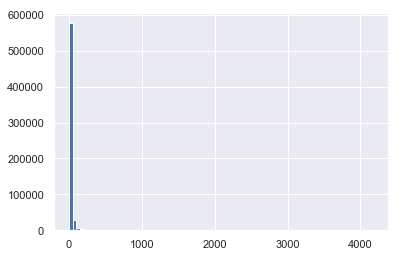

In [14]:
data['hits'].hist(bins=80)
plt.show()

In [15]:
# to avoid bias we will replace extreme values
n_replaced = (data['hits'] > 300).sum()
print(f'{n_replaced}/{len(data)} will be replaced')

1655/988681 will be replaced


In [16]:
data.loc[data['hits'] > 300, 'hits'] = 300

In [17]:
train = data[data['hits'].notnull()]
pred = data[data['hits'].isnull()]

In [18]:
train_X = train.drop(['row_num', 'hits'], axis=1)
train_y = train['hits']

pred_X = pred.drop(['row_num', 'hits'], axis=1)
pred_row_num = pred['row_num']

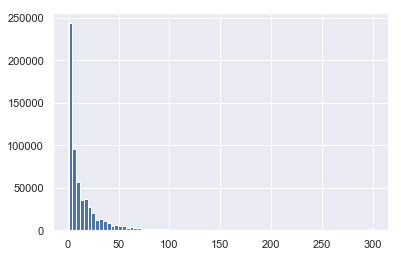

In [19]:
train_y.hist(bins=80)
plt.show()

In [20]:
X_train, X_test, y_train, y_test = train_test_split(train_X, train_y, test_size=0.25, random_state=7)

# Modelling

#### We are going to test 3 different models:
* Random Forest Regressor
* Linear Regression
* MLP


#### We split the data we have into several parts:

1) Data for prediction - data which have missing values in 'hits' column will be used for prediction<br>
2) Training-validating part - 75% of the data, which remains, will be used for training using Cross-validation technique<br>
3) Testing part - 25% of the data will be used just for testing the models


#### For each model we will perform several techniques:

* <b>5-Fold Cross Validation</b> - we split training-validation part into 5 folds. Then we train 5 different models with SAME parameters, but DIFFERENT data (4 different folds) and validate on the remaining fold (5th). For example, the first model will be trained on 1,2,3,4 folds and validated on 5th; the second model will be trained on 1,2,3,5 folds and will be validated on 4th fold, etc.. Then the validation results (using mean squared error) will be averaged accross 5 models. The average performance should give us the understanding how well the model performs.<br>
* <b>Grid-search</b> - since different ML algorithms can be used with different set of parameters (number of estimators, max depth, max features for Random Forest, etc..), but we do not know which set of parameters is the best, we can train models using different sets of parameters and choose the one, which shows the best results. So, we will define different sets of parameters for each ML algorithm and we will perform 5-fold Cross Validation to choose the best set of parameters for each algorithm.<br>

#### Objective function

To find the best set of parameters and the best model we will use mean squared error.<br>
<b>Mean squared error</b> is calculated as follows:<br>
1) Calculate difference between predicted value and real value<br>
2) Square the difference<br>
3) Sum up the squared differences and divide by the number of instances

<b>Note:</b> we take <u>negative</u> mean squared error in the objective function in GridSearch, because sklearn api is designed in such a way that it tries to maximize the score, but the objective is to minimize the error.

#### Error histogram
We will also evaluate our models visually using error histogram. Error histogram shows how much the predicted values deviate from the real values.

## Random Forest Regressor

Best params: {'max_depth': 10, 'max_features': 0.5, 'n_estimators': 25}
Best score: -543.4895393577282
Test mse: 534.2204857621438
 === ERROR HISTOGRAM ===


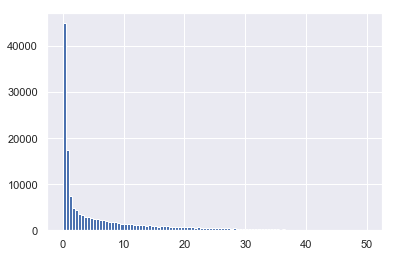

In [25]:
parameters = {'n_estimators':[15, 20, 25],
              'max_depth': [5, 10, 15],
              'max_features': [0.4, 0.5, 0.6]}

model_rf = GridSearchCV(RandomForestRegressor(), 
                        parameters, 
                        cv=5, 
                        verbose=True,
                        scoring='neg_mean_squared_error',
                        n_jobs=3)
model_rf.fit(X_train, y_train)

best_model_rf = model_rf.best_estimator_
preds_rf = best_model_rf.predict(X_test)
test_mse_rf = mean_squared_error(preds_rf, y_test)

print(f'Best params: {model_rf.best_params_}\n'
      f'Best score: {model_rf.best_score_}\n'
      f'Test mse: {test_mse_rf}')

print(' === ERROR HISTOGRAM ===')
difs_rf = abs(preds_rf - y_test)
plt.hist(difs_rf[difs_rf < 50], bins=100)
plt.show()

## Linear Regression

Best params: {}
Best score: -689.4802107257036
Test mse: 663.3428752288767
 === ERROR HISTOGRAM ===


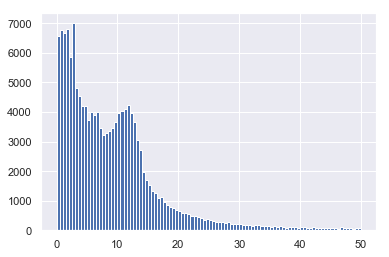

In [26]:
parameters = {}

model_lr = GridSearchCV(LinearRegression(), 
                        parameters, 
                        cv=5,
                        verbose=True, 
                        scoring='neg_mean_squared_error', 
                        n_jobs=3)
model_lr.fit(X_train, y_train)

best_model_lr = model_lr.best_estimator_
preds_lr = best_model_lr.predict(X_test)
test_mse_lr = mean_squared_error(preds_lr, y_test)

print(f'Best params: {model_lr.best_params_}\n'
      f'Best score: {model_lr.best_score_}\n'
      f'Test mse: {test_mse_lr}')

print(' === ERROR HISTOGRAM ===')
difs_lr = abs(preds_lr - y_test)
plt.hist(difs_lr[difs_lr < 50], bins=100)
plt.show()

## MLP

Best params: {'activation': 'relu', 'hidden_layer_sizes': (10, 10)}
Best score: -555.7938827883852
Test mse: 539.5327026000605
 === ERROR HISTOGRAM ===


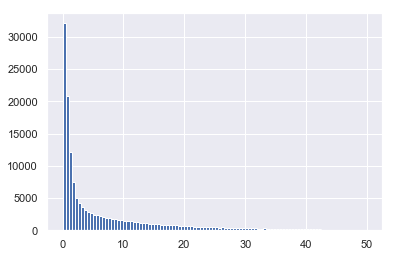

In [27]:
parameters = {'hidden_layer_sizes': [(5), (10), (5, 10), (10, 5), (10, 10)],
              'activation': ['relu']}

model_mlp = GridSearchCV(MLPRegressor(), 
                         parameters, 
                         cv=5, 
                         verbose=True, 
                         scoring='neg_mean_squared_error',
                         n_jobs=3)
model_mlp.fit(X_train, y_train)

best_model_mlp = model_mlp.best_estimator_
preds_mlp = best_model_mlp.predict(X_test)
test_mse_mlp = mean_squared_error(preds_mlp, y_test)

print(f'Best params: {model_mlp.best_params_}\n'
      f'Best score: {model_mlp.best_score_}\n'
      f'Test mse: {test_mse_mlp}')

print(' === ERROR HISTOGRAM ===')
difs_mlp = abs(preds_mlp - y_test)
plt.hist(difs_mlp[difs_mlp < 50], bins=100)
plt.show()

# Results

The performance on the test set among the 3 trained models is the following:<br>
* Random Forest Regressor: mse=534
* Linear Regression: mse=663
* MLP: mse=539

The Random Forest Regressor has shown the best performance during cross validation and testing, so we will choose it as our final model taken for predictions.

# Prediction

In [28]:
predictions = best_model_rf.predict(pred_X).astype(np.int)
predictions_df = pd.DataFrame({'id': pred_row_num, 'hits_prediction': predictions})
predictions_df.to_csv('predictions.csv', index=False)